In [1]:
import random
import math

class AlgoritmoGenetico:
    def __init__(self, dimensoes: int, limite_min: float, limite_max: float ,tamanho_populacao: int, num_fitness: int, tipo_selecao: int, tipo_cruzamento: int ,taxa_de_cruzamento: float, taxa_de_mutacao: float, qtd_geracoes:int):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.tamanho_populacao = tamanho_populacao
        self.tipo_selecao = tipo_selecao
        self.num_fitness = num_fitness
        self.tipo_cruzamento = tipo_cruzamento
        self.taxa_de_cruzamento = taxa_de_cruzamento
        self.taxa_de_mutacao = taxa_de_mutacao
        self.qtd_geracoes = qtd_geracoes

    def gerar_individuo(self):
        return [random.uniform(self.limite_min, self.limite_max) for i in range(self.dimensoes)]
    
    def gerar_populacao(self):
        return [self.gerar_individuo() for i in range(self.tamanho_populacao )]
    
    def sphere(self,individuo):
        resultado = 0
        for i in individuo:
            resultado += i ** 2
        return resultado
    
    def rastrigin(self,individuo):
        resultado = 0
        for i in individuo:
            numero = 2*3.1415*i
            p = (numero/180)*math.pi
            resultado+= (i**2) - (10 * math.cos(p)) + 10    
        return resultado
    
    def rosenbrock(self,individuo):
        resultado = 0
        for i in range(0,(len(individuo)-1)):
            resultado += 100*(individuo[i+1] - individuo[i]**2)**2 + (individuo[i] - 1)**2   
        return resultado

    def avaliar_populacao(self, populacao):
        funcao_fitness = (self.sphere if self.num_fitness == 1 
                        else self.rastrigin if self.num_fitness == 2
                        else self.rosenbrock  if self.num_fitness == 3
                        else self.sphere)
        avaliacao = []
        for individuo in populacao:
            avaliacao.append(funcao_fitness(individuo))
        return avaliacao

    def selecao_proporcional_fitness(self, populacao, avaliacao):
        lista_fitness_minimo = [1 / resultado for resultado in avaliacao]

        total_fitness_minimo = sum(lista_fitness_minimo)

        probabilidades = [valor/total_fitness_minimo for valor in lista_fitness_minimo]
        pais = random.choices(populacao, weights=probabilidades, k=self.tamanho_populacao)

        return pais

    def selecao_torneio(self, populacao, avaliacao):
        pais_vencedores = []

        for i in range(len(populacao)):
            participantes = random.sample(range(len(populacao)), 2)
            
            if avaliacao[participantes[0]] < avaliacao[participantes[1]]:
                vencedor = participantes[0]
            else:
                vencedor = participantes[1]
            
            pais_vencedores.append(populacao[vencedor])

        return pais_vencedores

    def cruzamento_1_ponto(self, pai1, pai2):
        num_random = random.random()
        filhos = []
        if num_random <= self.taxa_de_cruzamento:
            posicao = random.randint(1, len(pai1) - 1)
            filho1 = pai1[:posicao] + pai2[posicao:]
            filho2 = pai2[:posicao] + pai1[posicao:]
            filhos.append(filho1)
            filhos.append(filho2)
            return filhos
        else:
            filhos.append(pai1)
            filhos.append(pai2)
            return filhos

    def cruzamento_2_ponto(self,pai1, pai2):
        num_random = random.random()
        filhos = []
        if num_random <= self.taxa_de_cruzamento:
            num1 = random.randint(1, len(pai1) - 1)
            num2 = random.randint(1, len(pai1) - 1)
            while num1 == num2:
                num2 = random.randint(1, len(pai1) - 1)

            posicao = num1 if num1 < num2 else num2
            posicao2 = num2 if num1 < num2 else num1

            filho1 = pai1[:posicao] + pai2[posicao:posicao2] + pai1[posicao2:]
            filho2 = pai2[:posicao] + pai1[posicao:posicao2] + pai2[posicao2:]
            filhos.append(filho1)
            filhos.append(filho2)

            return filhos
        else:
            filhos.append(pai1)
            filhos.append(pai2)

            return filhos
    
    def cruzamento(self, pais, tipo_cruzamento):
        filhos = []

        if len(pais) % 2 == 0:
            for i in range(0, len(pais), 2):
                resultado_cruzamento = tipo_cruzamento(pais[i], pais[i+1])
                filhos.append(resultado_cruzamento[0])
                filhos.append(resultado_cruzamento[1])
        else:
            for i in range(0, len(pais) - 1, 2):
                resultado_cruzamento = tipo_cruzamento(pais[i], pais[i+1])
                filhos.append(resultado_cruzamento[0])
                filhos.append(resultado_cruzamento[1])
        
            resultado_cruzamento = tipo_cruzamento(pais[0], pais[-1])
            filhos.append(resultado_cruzamento[0])
            # filhos.append(resultado_cruzamento[1])

        return filhos

    def mutacao(self, filhos):
        for filho in filhos:
            for gene in range(0, len(filho)):
                num = random.random()
                if num <= self.taxa_de_mutacao:
                    filho[gene] = random.uniform(self.limite_min, self.limite_max)

        return filhos

    def executar(self):
        populacao = self.gerar_populacao()
        geracoes = 1

        nova_populacao = []
        melhores_fitness = []

        tipo_cruzamento = (self.cruzamento_1_ponto if self.tipo_cruzamento == 1 
                           else self.cruzamento_2_ponto)

        selecao = (self.selecao_proporcional_fitness if self.tipo_selecao == 1 
                   else self.selecao_torneio)

        while geracoes <= self.qtd_geracoes:
            # print(f'Geração {geracoes}')
            avaliacao = self.avaliar_populacao(populacao=populacao)
            selecao_pais = selecao(populacao=populacao, avaliacao=avaliacao)
            cruzamento_filhos = self.cruzamento(pais=selecao_pais, tipo_cruzamento=tipo_cruzamento)
            nova_populacao = self.mutacao(filhos=cruzamento_filhos)

            nova_avaliacao = self.avaliar_populacao(populacao=nova_populacao)
            melhores_fitness.append(min(nova_avaliacao))

            # print("NOVA POPULAÇÃO:")
            # for i in nova_populacao:
            #     print(i)
            # print()

            geracoes += 1

        nova_avaliacao = self.avaliar_populacao(populacao=nova_populacao)
        valor_minimo = min(nova_avaliacao)
        melhor_individuo = nova_populacao[nova_avaliacao.index(valor_minimo)]
    
        print(f"Geração {geracoes - 1}: Melhor Fitness = {valor_minimo}, Indivíduo = {melhor_individuo}")
        
        return melhores_fitness



Geração 10: Melhor Fitness = 1594.159725853373, Indivíduo = [-25.70164421877689, -18.096317091437953, -5.519480841819586, 23.992579045773766]


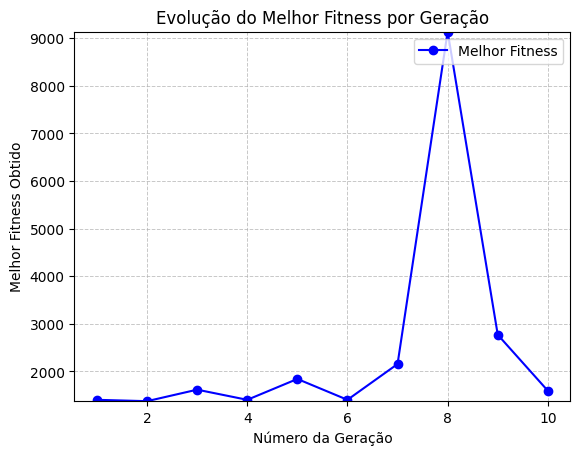

In [3]:
import matplotlib.pyplot as plt

alg = AlgoritmoGenetico(dimensoes = 4, 
                        limite_min= -100.0,
                        limite_max= 100.0,
                        tamanho_populacao = 10, 
                        tipo_selecao= 1, # 1 = Proporcional ao Fitness   # 2 = Torneio
                        num_fitness= 1,  # 1 = Sphere   2 = Rastrigin  3 = rosenbrock
                        tipo_cruzamento= 2,  # 1 = Cruzamento por 1 ponto     2 = Cruzamento por 2 pontos
                        taxa_de_cruzamento = 0.7, 
                        taxa_de_mutacao=0.01,
                        qtd_geracoes=10)

best_fitness = alg.executar()

# print()
# for i in best_fitness:
#     print(i)

x = [i for i in range(1, len(best_fitness) + 1)]
y = best_fitness

plt.plot(x, y, marker='o', linestyle='-', color='b', label='Melhor Fitness')

plt.title('Evolução do Melhor Fitness por Geração')
plt.xlabel('Número da Geração')
plt.ylabel('Melhor Fitness Obtido')

plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

plt.ylim(min(y) - 1, max(y) + 1)

plt.show()